Disclaimer:
I was not able to import the data_cleaning collab file as a module so for the moment this is a copy of data_cleaning with some addition at the end to run a quick baseline with scikit learn 



In [0]:
import os
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt

In [0]:
import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline,linear_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
import keras
import re
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

In [0]:
!wget https://propaganda.qcri.org/semeval2020-task11/data/datasets-v2.tgz
!tar xzvf datasets-v2.tgz

In [0]:
train_articles = os.listdir("datasets/train-articles")
train_labels_tags_span = os.listdir("datasets/train-labels-task1-span-identification")
train_tags_technique = os.listdir("datasets/train-labels-task2-technique-classification")
train_articles.sort()
train_labels_tags_span.sort()

Step 1: Gather tables from Task 1 folder and place them into a dict type where the article number is the key

In [0]:
# Dictionary containing news articlc
propTagsSpan = {}

for i in range(len(train_articles)):
    article = train_articles[i]
    #removing .txt file extension
    articleNoExt = os.path.splitext(article)[0]
    #replace train articles with the same name 
    train_articles[i] = articleNoExt
    #removing article
    articleNo = articleNoExt.replace('article','')
    tagPath = "datasets/train-labels-task1-span-identification/"+ articleNoExt + ".task1-SI.labels"
    with open(tagPath) as r:
        tags = r.readlines()
        for i in range(len(tags)):
            tag = tags[i]
            tag = tag.replace("\t"," ")
            tag = tag.replace("\n"," ")
            tags[i] = tag
        propTagsSpan[articleNoExt] = tags
    r.close()
    
print(propTagsSpan[train_articles[0]])
    

['111111111 265 323 ', '111111111 1795 1935 ', '111111111 149 157 ', '111111111 1069 1091 ', '111111111 1334 1462 ', '111111111 1577 1616 ', '111111111 2023 2086 ']


Step 2: Do the same for task 2

In [0]:
propagandaTagTechnique = os.listdir("datasets/train-labels-task2-technique-classification")
propagandaTagTechnique.sort()
propTagsTechnique = {}

for i in range(len(train_articles)):
    article = train_articles[i]
    #removing .txt file extension
    articleNoExt = os.path.splitext(article)[0]
    #replace train articles with the same name 
    train_articles[i] = articleNoExt
    #removing article
    articleNo = articleNoExt.replace('article','')
    tagPath = "datasets/train-labels-task2-technique-classification/"+ articleNoExt + ".task2-TC.labels"
    
    with open(tagPath) as r:
        tags = r.readlines()
        for i in range(len(tags)):
            tag = tags[i]
            tag = tag.replace(articleNo, " ")
            tag = tag.replace("\t"," ")
            tag = tag.replace("\n"," ")
            tags[i] = tag
        propTagsTechnique [articleNoExt] = tags
    r.close()
    
print(propTagsTechnique[train_articles[0]])
    

['  Appeal_to_Authority 265 323 ', '  Appeal_to_Authority 1795 1935 ', '  Doubt 149 157 ', '  Repetition 1069 1091 ', '  Appeal_to_fear-prejudice 1334 1462 ', '  Appeal_to_fear-prejudice 1577 1616 ', '  Appeal_to_fear-prejudice 1856 1910 ', '  Appeal_to_fear-prejudice 2023 2086 ']


Step 3: Put sentences that have annotation "propoganda" as a list

In [0]:
propoganda_sent_span = []

for article in train_articles:
    article_path = "datasets/train-articles/" + article + ".txt"
    tags = propTagsSpan[article]
    
    with open(article_path, encoding="utf-8") as r:
        entireArticle = r.read()
        for tag in tags:
            tag = tag.split()
            start = int(tag[1])
            end = int(tag[2])
            
            tag_line = entireArticle[start:end]
            tag_line = tag_line.replace("\n", " ")
            tag_line = tag_line.replace("\t", " ")
            
            propoganda_sent_span.append(tag_line)
    r.close()

print(propoganda_sent_span[0])

The next transmission could be more pronounced or stronger


Step 4: Create a dictionary with the keys being the propoganda sentences and the values being their associated propoganda type. 

In [0]:
propoganda_techniques = {}
propoganda_techniques["Sentence"] = []
propoganda_techniques["Technique"] = []

for article in train_articles:
    article_path = "datasets/train-articles/" + article + ".txt"
    tags = propTagsTechnique[article]
    
    with open(article_path, encoding="utf-8") as r:
        entireArticle = r.read()
        for tag in tags:
            tag = tag.split()
            propoganda_techniques["Technique"].append(tag[0])
            start = int(tag[1])
            end = int(tag[2])
            
            tag_line = entireArticle[start:end]
            tag_line = tag_line.replace("\n", " ")
            tag_line = tag_line.replace("\t", " ")
            propoganda_techniques["Sentence"].append(tag_line)     
    r.close()  

Step 5: Using the list of propoganda sentences to create a list of non propoganda sentences

Step 6: Convert dictionary into DataFrame


In [0]:
df = pd.DataFrame.from_dict(propoganda_techniques)
df

,Sentence,Technique
0,The next transmission could be more pronounced...,Appeal_to_Authority
1,when (the plague) comes again it starts from m...,Appeal_to_Authority
2,appeared,Doubt
3,"a very, very different",Repetition
4,He also pointed to the presence of the pneumon...,Appeal_to_fear-prejudice
...,...,...
6124,the Left killed comedy,Slogans
6125,"no one looks in the mirror and thinks, ‘this b...","Exaggeration,Minimisation"
6126,Columbia snowflakes,"Name_Calling,Labeling"
6127,"Comrades, these jokes you have been listening ...","Exaggeration,Minimisation"


Step 7: Plot data per class


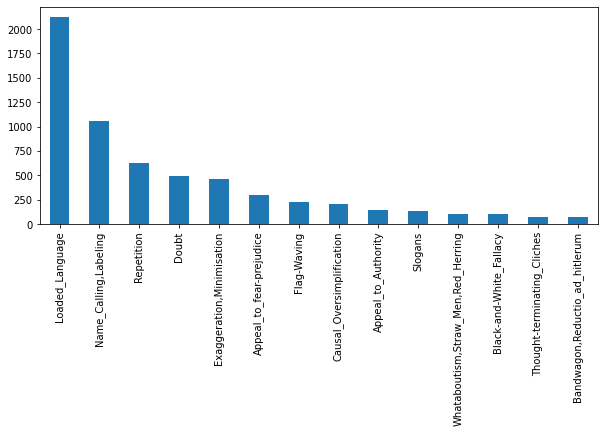

In [0]:
propoganda_techniques_tags = ['Appeal_to_Authority','Name_Calling,Labeling','Slogans', 'Loaded_Language','Appeal_to_fear-prejudice','Repetition','Doubt','Exaggeration,Minimisation','Flag-Waving','Causal_Oversimplification','Whataboutism,Straw_Men,Red_Herring','Black-and-White_Fallacy','Thought-terminating_Cliches','Bandwagon,Reductio_ad_hitlerum']
plt.figure(figsize=(10,4))
df.Technique.value_counts().plot(kind='bar');

Step 8: inspect language by checking sentence - tag pair 

In [0]:
def print_plot(index):
    example = df[df.index == index][['Sentence', 'Technique']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Tag:', example[1])

print_plot(20)

pinned blame for Steinle's death on illegal immigration and insufficiently aggressive deportation policies
Tag: Causal_Oversimplification


In [0]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Step 10: Prepocessing - even if the data is very clean #to check

---



In [0]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
#BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]') 
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    #text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text - not sure if we want to do this
    return text
    
df['Sentence'] = df['Sentence'].apply(clean_text)
print_plot(20)

pinned blame steinle's death illegal immigration insufficiently aggressive deportation policies
Tag: Causal_Oversimplification


step 11: Count number of token post preprocessing

In [0]:
df['Sentence'].apply(lambda x: len(x.split(' '))).sum()

28602

Step 12: split the training data into train and test sets

In [0]:
X = df.Sentence
y = df.Technique
#random_state sets a seed, the train-test splits are always deterministic. If the seed is not set, train-test splits are different each time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42) 

In [0]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np 
enc = OneHotEncoder(handle_unknown='ignore')
print(X_train.shape)
y_test= np.idxmax(y_test, axis=1)
#X_train = X_train.reshape(-1, 1)
#enc.fit(X)

(4903,)


AttributeError: ignored

Step 13: create a ML pipeline where we stack the Sentence vectorisation (TFIDF, CountVec) and the model - This structure will repaet later but we'll change the models

In [0]:


from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
lr = LogisticRegression()

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)



In [0]:
import imblearn 
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer

tvec = TfidfVectorizer(stop_words = None, max_features=100000, ngram_range=(1, 3))

ROS_pipeline = make_pipeline(tvec, RandomOverSampler(random_state=777),lr)

tv = TfidfVectorizer(stop_words=None, max_features=100000)
testing_tfidf = tv.fit_transform(X_train)
ros = RandomOverSampler(random_state=777)
X_ROS, y_ROS = ros.fit_sample(testing_tfidf, y_train)
pd.DataFrame(testing_tfidf.todense(), columns=tv.get_feature_names())

In [0]:
pd.DataFrame(X_ROS.todense(), columns=tv.get_feature_names())

y_ROS

In [0]:
from sklearn.preprocessing import MultiLabelBinarizer
import imblearn 
from imblearn.over_sampling import SMOTE 

mlb = MultiLabelBinarizer()
mlb_transform = mlb.fit_transform(df["Technique"].str.split(","))
print(mlb_transform)
print(mlb.classes_)

smote = SMOTE('minority')

x_sm, y_sm = smote.fit_sample(X_ROS, y_ROS)
#print(x_sm.shape, y_sm.shape)
pd.DataFrame(x_sm.todense(), columns=tv.get_feature_names())

Step 14: Check predictions metrics

In [0]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=propoganda_techniques_tags))
print(f1_score(y_test, y_pred, average='weighted'))

Step 15: Baseline with Logistic Regression


In [0]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(solver='lbfgs', multi_class='auto')),
               ])
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=propoganda_techniques_tags))
print(f1_score(y_test, y_pred, average='weighted'))

Baseline with Linear classifiers (SVM, logistic regression, a.o.) with SGD training

In [0]:
from sklearn.linear_model import SGDClassifier
tfidf_word = TfidfVectorizer(ngram_range=(1, 3))
tfidf_char = TfidfVectorizer(analyzer='char', ngram_range=(1, 3))
count_word = CountVectorizer(ngram_range=(1, 3))
count_char = CountVectorizer(analyzer='word', ngram_range=(1, 3))
sgd = Pipeline([
                ('features', FeatureUnion([
                                          ('vect',count_word),
                                          ('tfidf', tfidf_word)
                                          ])),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=propoganda_techniques_tags))
print(f1_score(y_test, y_pred, average='macro'))

Work in progress under here

In [0]:
import gensim
from gensim.models import Word2Vec

In [0]:
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

In [0]:
embeddings = '/root/input/GoogleNews-vectors-negative300.bin.gz' # from above
from gensim.models import Word2Vec

wv = gensim.models.KeyedVectors.load_word2vec_format(embeddings, binary=True)
wv.init_sims(replace=True)

In [0]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        print("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list])

In [0]:
import nltk
import numpy as np
nltk.download('all')
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens
    
train, test = train_test_split(df, test_size=0.2, random_state = 42)

test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['Sentence']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['Sentence']), axis=1).values

X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

In [0]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(X_train_word_average, train['Technique'])
y_pred = logreg.predict(X_test_word_average)
print('accuracy %s' % accuracy_score(y_pred, test.Technique))
print(classification_report(test.Technique, y_pred))

In [0]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
print(mlb.fit_transform(df["Technique"].str.split(",")))
print(mlb.classes_)

import imblearn 
from imblearn.over_sampling import SMOTE 

smote = SMOTE('minority')

x_sm, y_sm = smote.fit_sample(X_train, y_train)
#print(x_sm.shape, y_sm.shape)
pd.DataFrame(x_sm.todense(), columns=tv.get_feature_names())